<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P6: Classifiez automatiquement des biens de consommation </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 2 - 2/2: Traitement avec des techniques recentes** </span> </font>  

**Contexte**  
**Place de marché** est une entreprise qui propose souhaite lancer une marketplace e-commerce.
<img src="PlaceDeMarche.png" width="400" height="200"> 
**Mission**   
* **Partie 1:**  
Réaliser une première **étude de faisabilité** de regroupement des produits de même catégorie via les descriptions ;
    * **1. textuelle** 
    * **2. image**    
de ces produits.
* **Partie 2:**  
Réaliser une **classification supervisée** à partir des images;
    * **1. avec des techniques classiques**  
    * **2. avec des techniques recentes**

# Importation des données et des librairies Python pour DS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
data = pd.read_csv('./data/Traited/data_categories_image.csv')
print(data.shape)
data.head()

(1050, 4)


,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,./data/Images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,./data/Images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,./data/Images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,./data/Images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,./data/Images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,4


In [3]:
data_train = pd.read_csv('./data/Traited/dataset_train.csv')
print(data_train.shape)
data_train.head(2)

(900, 3)


,image_path,label_name,label
0,./data/Images/c7207128c680a437e1cad834a8880007...,Watches,6
1,./data/Images/417ae3e8b08acc19a023b8a958644799...,Beauty and Personal Care,1


In [4]:
data_test = pd.read_csv('./data/Traited/dataset_test.csv')
print(data_test.shape)
data_test.head(2)

(150, 3)


,image_path,label_name,label
0,./data/Images/833a87b0af3b84fe246d2ebf271af177...,Computers,2
1,./data/Images/55195de3873fffaa9e37b041533d7305...,Kitchen & Dining,5


In [72]:
# import shutil

# # Créer les dossiers pour chaque catégorie
# categories = data['label_name'].unique()
# for cat in categories:
#     os.makedirs(cat, exist_ok=True)

# # Copier les images dans les dossiers appropriés
# for i, row in data.iterrows():
#     cat = row['label_name']
#     img_path = row['image_path']
#     shutil.copy(img_path, os.path.join(cat, os.path.basename(img_path)))

# Approche nouvelle par Dataset sans data augmentation

La méthode tf.keras.utils.image_dataset_from_directory réalise plusieurs prétraitements sur les images avant de les utiliser pour l'entraînement ou l'évaluation d'un modèle de deep learning.

Voici les principaux prétraitements effectués par cette méthode :

Redimensionnement : Par défaut, les images sont redimensionnées en entrée du modèle à la taille spécifiée dans l'argument image_size. Cela garantit que toutes les images ont la même taille, ce qui est une condition nécessaire pour que les images puissent être traitées en entrée d'un modèle de deep learning.

Normalisation : Les valeurs de pixel de chaque image sont divisées par 255 pour normaliser les intensités de pixels entre 0 et 1. Cela permet de stabiliser la distribution des valeurs de pixels entre les images et facilite l'optimisation du modèle.

Data Augmentation : Par défaut, la méthode tf.keras.utils.image_dataset_from_directory applique une augmentation de données légère aux images lors de l'entraînement du modèle. Cela consiste à appliquer des transformations aléatoires telles que des rotations, des translations, des zooms et des flips horizontaux sur les images. L'objectif de cette technique est de générer des images supplémentaires pour éviter le surapprentissage et améliorer la généralisation du modèle.

Conversion en tenseurs : Les images sont converties en tenseurs pour pouvoir être utilisées en entrée d'un modèle de deep learning. Par défaut, les tenseurs sont de type float32 et ont une forme (batch_size, image_height, image_width, num_channels), où batch_size correspond au nombre d'images dans le batch, image_height et image_width sont les dimensions des images redimensionnées, et num_channels est le nombre de canaux de couleur (3 pour les images RGB, 1 pour les images en niveaux de gris).

In [5]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [6]:
path = "./Image_cat/"
path_test = "./Image_cat_test/"
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 904 files belonging to 7 classes.
Using 678 files for training.
Found 904 files belonging to 7 classes.
Using 226 files for validation.
Found 146 files belonging to 7 classes.


In [7]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [8]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num CPUs Available:  1


In [10]:
with tf.device('/cpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 6.2087 - accuracy: 0.4764
Epoch 1: val_loss improved from inf to 2.05002, saving model to .\model3_best_weights.h5
22/22 [==============================] - 146s 7s/step - loss: 6.2087 - accuracy: 0.4764 - val_loss: 2.0500 - val_accuracy: 0.7168
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 2.4678 - accuracy: 0.6903
Epoch 2: val_loss improved from 2.05002 to 1.50288, saving model to .\model3_best_weights.h5
22/22 [==============================] - 140s 6s/step - loss: 2.4678 - accuracy: 0.6903 - val_loss: 1.5029 - val_accuracy: 0.7478
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 1.4574 - accuracy: 0.7581
Epoch 3: val_loss improved from 1.50288 to 1.37942, saving model to .\model3_best_weights.h5
22/22 [==============================] - 140s 6s/step - loss: 1.4574 - accuracy: 0.7581 - val_loss: 1.3794 - val_accuracy: 0.7699
Epoch 4/50
22/22 [==============================] - E

In [11]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

22/22 [==============================] - 101s 5s/step - loss: 0.0137 - accuracy: 0.9941
Training Accuracy   : 0.9941

8/8 [==============================] - 35s 4s/step - loss: 1.3313 - accuracy: 0.8053
Validation Accuracy :  0.8053


In [12]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7920
Test Accuracy       :  0.8082


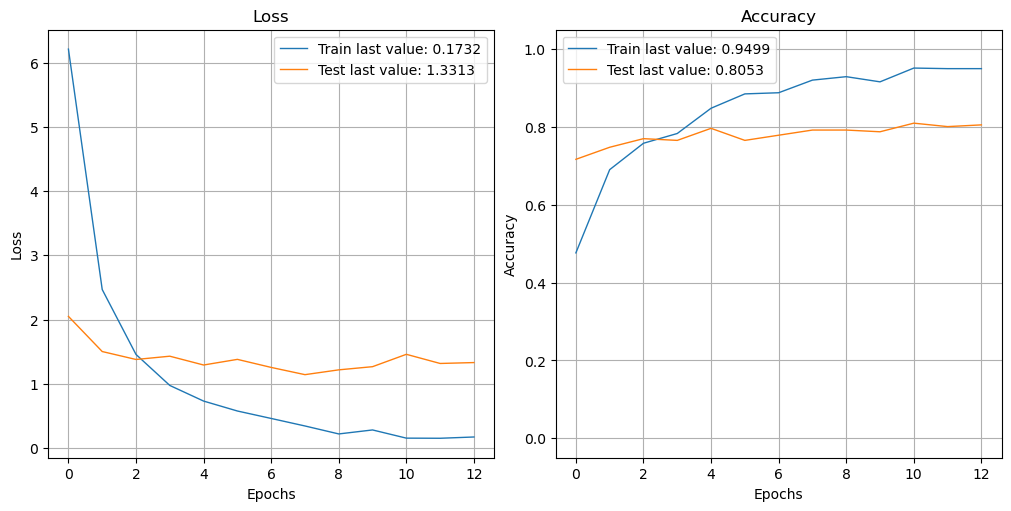

In [13]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

# Approche nouvelle par Dataset avec data augmentation intégrée 

**L'approche dataset avec data augmentation intégrée** est une méthode pour préparer les données d'entraînement d'un modèle de réseau de neurones convolutionnel, qui combine les avantages de l'approche dataset et de l'augmentation de données.

Dans cette approche, les données sont stockées dans un fichier ou une base de données, puis prétraitées comme dans l'approche dataset traditionnelle. Cependant, au lieu de simplement diviser les données en ensembles de formation, de validation et de test, les données d'entraînement sont augmentées en temps réel à l'aide de techniques d'augmentation de données telles que la rotation, le zoom, le décalage et la symétrie horizontale. Ces techniques sont appliquées aléatoirement à chaque image pendant l'entraînement, ce qui crée des variations des images originales, augmentant ainsi la quantité de données d'entraînement disponibles.

L'approche dataset avec data augmentation intégrée permet d'obtenir des performances similaires à celles de l'approche dataset traditionnelle avec l'augmentation de données appliquée séparément, mais avec moins de temps et d'efforts pour préparer les données. De plus, cette approche peut être plus efficace pour des ensembles de données plus petits où l'augmentation de données séparée peut ne pas être suffisamment diversifiée pour capturer la variabilité des données réelles.

In [73]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [86]:
path = "./Image_cat/"
path_test = "./Image_cat_test/"
train_dataset = dataset_fct(path, validation_split=0.25, data_type='training')
val_dataset = dataset_fct(path, validation_split=0.25, data_type='validation')
test_dataset = dataset_fct(path_test, validation_split=0, data_type=None)

Found 904 files belonging to 7 classes.
Using 678 files for training.
Found 904 files belonging to 7 classes.
Using 226 files for validation.
Found 146 files belonging to 7 classes.


In [87]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

create_model_fct2 crée un modèle de réseau de neurones convolutifs pour la classification d'images en utilisant l'architecture VGG16 comme modèle de base. Voici un résumé de ce que fait la fonction :

Augmentation de données : Elle applique des techniques d'augmentation de données aux images d'entrée, notamment des retournements, des rotations et des zooms aléatoires. Ces techniques permettent d'augmenter la diversité des données d'entraînement et d'améliorer la capacité du modèle à généraliser.

Modèle de base : Elle charge le modèle VGG16 comme modèle de base, avec des poids pré-entraînés à partir de "imagenet".

Nouveau modèle : Elle définit le nouveau modèle en ajoutant une couche de normalisation des données, le modèle de base VGG16, une couche de mise en commun globale, deux couches de neurones densément connectées et une couche de sortie softmax pour la classification multiclasse.

Compilation du modèle : Elle compile le modèle en spécifiant la fonction de perte, l'optimiseur et les métriques à utiliser pendant l'entraînement.

Enfin, la fonction retourne le modèle compilé prêt.

In [88]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [82]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [89]:
with tf.device('/cpu:0'): 
    history4 = model4.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.8540
Epoch 1: val_loss improved from 0.57237 to 0.39715, saving model to .\model4_best_weights.h5
22/22 [==============================] - 153s 7s/step - loss: 0.4724 - accuracy: 0.8540 - val_loss: 0.3971 - val_accuracy: 0.8717
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8643
Epoch 2: val_loss did not improve from 0.39715
22/22 [==============================] - 159s 7s/step - loss: 0.4497 - accuracy: 0.8643 - val_loss: 0.4023 - val_accuracy: 0.8761
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8555
Epoch 3: val_loss did not improve from 0.39715
22/22 [==============================] - 156s 7s/step - loss: 0.4608 - accuracy: 0.8555 - val_loss: 0.4128 - val_accuracy: 0.8850
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8643
Epoch 4: val_loss did not improve from 0.39715


In [90]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(train_dataset, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(val_dataset, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

22/22 [==============================] - 107s 5s/step - loss: 0.2638 - accuracy: 0.9218
Training Accuracy   : 0.9218

8/8 [==============================] - 40s 4s/step - loss: 0.4012 - accuracy: 0.8717
Validation Accuracy :  0.8717


In [91]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(val_dataset, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(test_dataset, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8717
Test Accuracy       :  0.8630


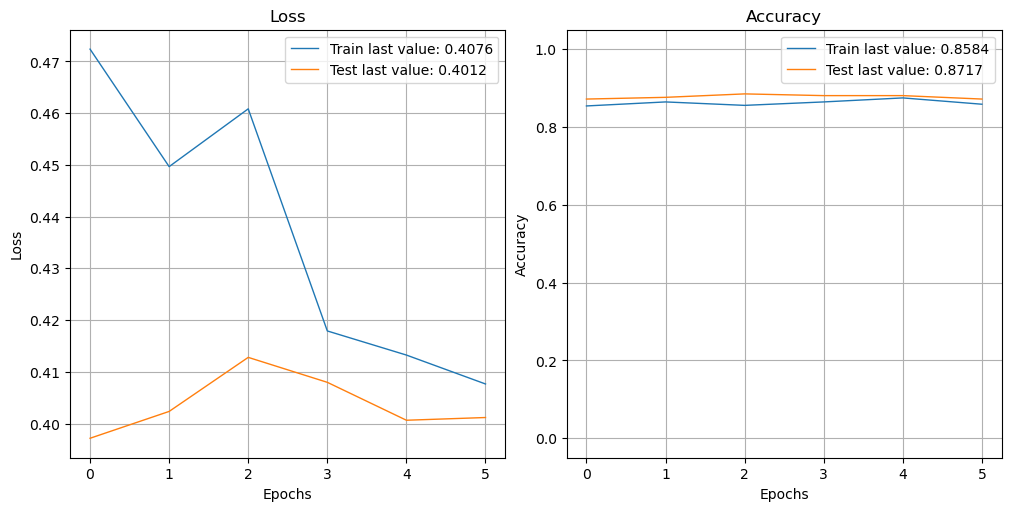

In [92]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# Comparaison entre les modèles

In [16]:
import pandas as pd
training = [1, 0.97, 0.99, 0.92] 
validation = [0.81, 0.83, 0.8, 0.87]
testing = [0.79, 0.78, 0.8, 0.86]
approches = ['Approche_1', 'Approche_2', 'Approche_3', 'Approche_4']
results = pd.DataFrame(data={'Training': training,
                           'Validation': validation,
                           'Testing': testing}, index=approches)
results

,Training,Validation,Testing
Approche_1,1.00,0.81,0.79
Approche_2,0.97,0.83,0.78
Approche_3,0.99,0.80,0.80
Approche_4,0.92,0.87,0.86


In [25]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Training', x=approches, y=training),
    go.Bar(name='Validation', x=approches, y=validation),
    go.Bar(name='Testing', x=approches, y=testing)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [24]:
import plotly.graph_objects as go
animals=['giraffes', 'orangutans', 'monkeys']

fig = go.Figure(data=[
    go.Bar(name='SF Zoo', x=animals, y=[20, 14, 23]),
    go.Bar(name='LA Zoo', x=animals, y=[12, 18, 29])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [18]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
